In [1]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\HP\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [3]:
df = pd.read_csv("C:/Users/HP/Desktop/ledoux/residents/Dr Mbobara/Data base Mbobara(1)_machine_learning.csv", sep=',')
df.head(5)

,cancer,age,crp_pleu,ldh,proteins,glucose,IMC,metastasis
0,2,62,40.70,376,48.0,0.36,20.307412,1
1,2,62,179.88,1374,38.4,0.81,19.379197,0
2,2,29,150.69,1157,64.0,0.84,19.605192,0
3,2,32,143.20,2475,53.6,0.95,21.799308,0
4,2,29,140.12,593,74.1,1.04,22.408179,0


In [4]:
#Verification des valeurs manquantes
df.isnull().any()

cancer        False
age           False
crp_pleu      False
ldh           False
proteins      False
glucose       False
IMC           False
metastasis    False
dtype: bool

In [5]:
# import a module to split dataset in train set and test set
from sklearn.model_selection import train_test_split

In [6]:
# Defining target(y) and features (X)
y = df['metastasis']
X = df.drop(columns =['metastasis'])

print("X:", list(df.columns))
print("X shape:", X.shape)
print("y shape:", y.shape)

X: ['cancer', 'age', 'crp_pleu', 'ldh', 'proteins', 'glucose', 'IMC', 'metastasis']
X shape: (302, 7)
y shape: (302,)


In [7]:
#Separer la base en train et test set
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, 
                                                    stratify=y, random_state=0 )

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (241, 7)
y_train shape: (241,)
X_test shape: (61, 7)
y_test shape: (61,)


In [8]:
# Packages for models training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.metrics import specificity_score

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [12]:
#Fonction d'evaluation
def evaluation(model, X_test=X_test):
    # Importer les modules nécessaires pour le calcul des métriques
    from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score
    from imblearn.metrics import specificity_score
    # Prédictions sur les données du test set
    ypred = model.predict(X_test)
    # Calcul de l'AUC et spécificité
    model_probs = model.predict_proba(X_test)
    model_probs = model_probs[:, 1]
    model_auc = roc_auc_score(y_test, model_probs)
    spe = specificity_score(y_test, ypred, average=None)
    # Matrice de confuson et scores associés dont F1
    print("CONFUSION MATRIX")
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    print("SPECIFICITY")
    print(spe)
    print("AUROC")
    print(model_auc)

#### Equilibrer les données avec under sampling: diminuer les données des classes majoritaires pour les équilibrer sur la classe minoritaires

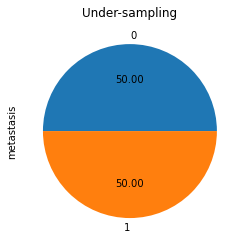

In [13]:
#from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=1) 
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

ax = y_train_rus.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

In [14]:
y_train_rus.value_counts()

0    38
1    38
Name: metastasis, dtype: int64

In [15]:
X_train_rus.shape

(76, 7)

In [16]:
RF_und = RandomForestClassifier(random_state=1)
LR_und = LogisticRegression(random_state=1)
GB_und= GradientBoostingClassifier(random_state=1)
ANN_und = MLPClassifier(random_state=1)

## Random Forest 

In [17]:
RF_und.fit(X_train_rus, y_train_rus)

RandomForestClassifier(random_state=1)

In [18]:
# Recherche des hyperparamètres optimaux
# Définir la plage des hyperparamètres
distributions = dict(max_depth=np.arange(1,10),
                     n_estimators=np.arange(60,600))

# Configurer la recherche aléatoire
Rand_CV = RandomizedSearchCV(RF_und, distributions, random_state=0, scoring = 'roc_auc')
search =  Rand_CV.fit(X_train_rus, y_train_rus)
 
search.best_params_ 

{'n_estimators': 553, 'max_depth': 2}

In [19]:
# Entraînement avec les hyperparamètres optimaux
RF_und_final = RandomForestClassifier(n_estimators = 92, max_depth= 6, random_state=0)
RF_und_final.fit(X_train_rus, y_train_rus)

RandomForestClassifier(max_depth=6, n_estimators=92, random_state=0)

0.9986149584487535


Text(0.5, 0, 'Taux de faux positifs')

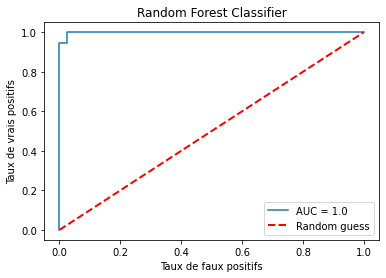

In [92]:
yPred1 = RF_und_final.predict_proba(X_train_rus)
yPred1 = yPred1[:, 1]

fpr, tpr, _ = roc_curve(y_train_rus, yPred1)
roc_auc = auc(fpr, tpr)
print(roc_auc_score(y_train_rus, yPred1))
plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.legend(loc='lower right')
plt.title('Random Forest Classifier')
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')

In [20]:
# Calcul du score obtenu durant la validation croisée pour le modèle de RF avce les hyperparamètres optimaux
cross_validation =10
score_f1_final = cross_val_score(RF_und_final, X_train_rus, y_train_rus, cv=cross_validation, scoring ="f1")
score_auc_final = cross_val_score(RF_und_final, X_train_rus, y_train_rus, cv=cross_validation, scoring ="roc_auc")
print('score folds F1 final')
print(score_f1_final)
print('Mean CV F1 final', '{:.3f}'.format(score_f1_final.mean()))
print('standard deviation CV F1 final', '{:.3f}'.format(np.std(score_f1_final)))
print('####################################################################')

print('score folds AUC final')
print(score_auc_final)
print('Mean CV AUC final:', '{:.3f}'.format(score_auc_final.mean()))
print('standard deviation CV AUC final:', '{:.3f}'.format(np.std(score_auc_final)))

score folds F1 final
[0.4        0.72727273 0.85714286 0.57142857 0.88888889 0.66666667
 0.75       0.75       0.66666667 0.66666667]
Mean CV F1 final 0.694
standard deviation CV F1 final 0.133
####################################################################
score folds AUC final
[0.5625     0.6875     0.9375     0.6875     1.         0.9375
 0.83333333 0.66666667 0.75       1.        ]
Mean CV AUC final: 0.806
standard deviation CV AUC final: 0.149


In [21]:
print("Random forest model de base")
evaluation(RF_und_final)

Random forest model de base
CONFUSION MATRIX
[[33 18]
 [ 3  7]]
              precision    recall  f1-score   support

           0       0.92      0.65      0.76        51
           1       0.28      0.70      0.40        10

    accuracy                           0.66        61
   macro avg       0.60      0.67      0.58        61
weighted avg       0.81      0.66      0.70        61

SPECIFICITY
[0.7        0.64705882]
AUROC
0.7843137254901961


C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

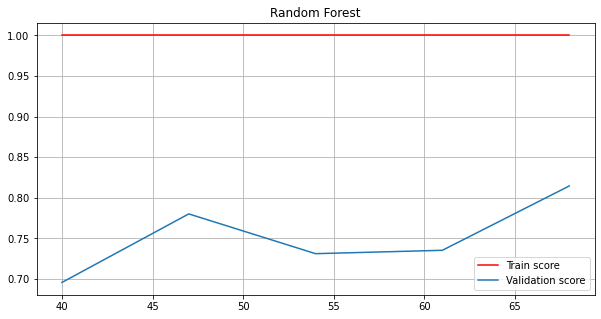

In [22]:
from sklearn.model_selection import learning_curve

N, train_score_RF_und, val_score_RF_und = learning_curve(RF_und_final, X_train_rus, y_train_rus,  scoring='roc_auc',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

figure, axis = plt.subplots(figsize=(10, 5))

# For RF
axis.plot(N, train_score_RF_und.mean(axis=1), color = "red")    
axis.plot(N, val_score_RF_und.mean(axis=1))
axis.set_title("Random Forest")
axis.legend(['Train score', 'Validation score'])
axis.grid(visible = None)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

[ 6 13 20 27 34 40 47 54 61 68]


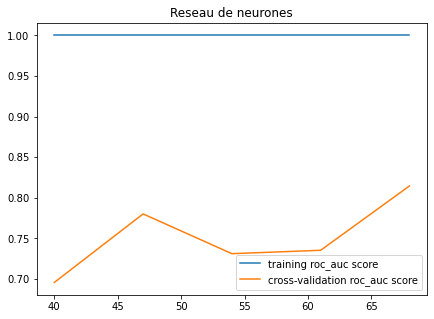

In [23]:
N, train_score_RF_und, val_score_RF_und = learning_curve(RF_und_final, X_train_rus, y_train_rus,  scoring='roc_auc',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

print(N)
plt.figure(figsize=(7, 5))
plt.plot(N, train_score_RF_und.mean(axis=1), label='training roc_auc score')
plt.plot(N, val_score_RF_und.mean(axis=1), label='cross-validation roc_auc score')
plt.xlabel('')
plt.title('Reseau de neurones')

plt.legend()
plt.show()

0.7843137254901961


Text(0.5, 0, 'Taux de faux positifs')

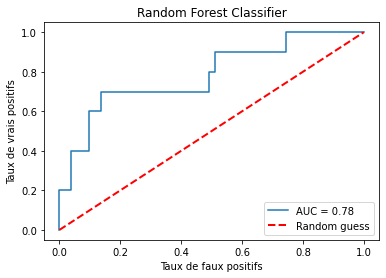

In [24]:
from sklearn.metrics import roc_curve, auc

yPred = RF_und_final.predict_proba(X_test)
yPred = yPred[:, 1]

fpr, tpr, _ = roc_curve(y_test, yPred)
roc_auc = auc(fpr, tpr)
print(roc_auc_score(y_test, yPred))
plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.legend(loc='lower right')
plt.title('Random Forest Classifier')
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')

## Gradient Boosting

In [25]:
# Initialisation et choix du modèle
GB_und.fit(X_train_rus, y_train_rus)

GradientBoostingClassifier(random_state=1)

In [26]:
#Recherches des hyperparamètres optimaux
distributions = dict(max_depth=np.arange(1,10),
                     n_estimators=np.arange(60,600))

# Configurer la recherche aléatoire
Rand_CV = RandomizedSearchCV(GB_und, distributions, random_state=1, scoring = 'roc_auc')
search =  Rand_CV.fit(X_train_rus, y_train_rus)
 
search.best_params_ 

{'n_estimators': 182, 'max_depth': 3}

In [27]:
GB_und_final = GradientBoostingClassifier(n_estimators = 182, max_depth= 3, random_state=0)
GB_und_final.fit(X_train_rus, y_train_rus)

GradientBoostingClassifier(n_estimators=182, random_state=0)

In [28]:
# Calcul du score obtenu durant la validation croisée pour le modèle de base sur le train set

cross_validation =10 
score_f1 = cross_val_score(GB_und_final, X_train_rus, y_train_rus, cv=cross_validation, scoring ="f1")
score_auc = cross_val_score(GB_und_final, X_train_rus, y_train_rus, cv=cross_validation, scoring ="roc_auc")
print('score folds F1')
print(score_f1)
print('Mean CV F1', '{:.3f}'.format(score_f1.mean()))
print('standard deviation CV F1', '{:.3f}'.format(np.std(score_f1)))
print('####################################################################')

print('score folds AUC')
print(score_auc)
print('Mean CV AUC:', '{:.3f}'.format(score_auc.mean()))
print('standard deviation CV AUC:', '{:.3f}'.format(np.std(score_auc)))

score folds F1
[0.         0.6        0.         0.75       0.88888889 0.66666667
 0.57142857 0.66666667 0.66666667 0.66666667]
Mean CV F1 0.548
standard deviation CV F1 0.286
####################################################################
score folds AUC
[0.3125     0.375      0.875      0.875      0.875      0.875
 0.66666667 0.58333333 0.5        0.75      ]
Mean CV AUC: 0.669
standard deviation CV AUC: 0.206


In [29]:
print("Gradient Boosting")
evaluation(model=GB_und_final)

Gradient Boosting
CONFUSION MATRIX
[[27 24]
 [ 4  6]]
              precision    recall  f1-score   support

           0       0.87      0.53      0.66        51
           1       0.20      0.60      0.30        10

    accuracy                           0.54        61
   macro avg       0.54      0.56      0.48        61
weighted avg       0.76      0.54      0.60        61

SPECIFICITY
[0.6        0.52941176]
AUROC
0.6607843137254902


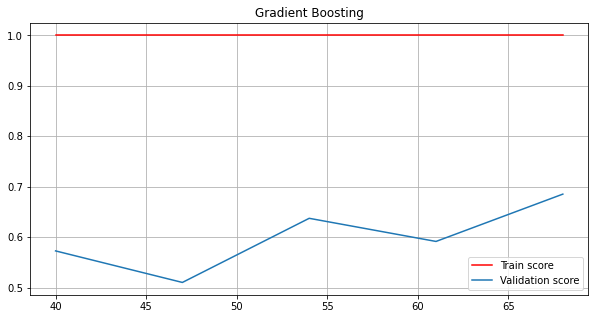

In [30]:
N, train_score_GB_und_final, val_score_GB_und_final = learning_curve(GB_und_final, X_train_rus, y_train_rus,  scoring='roc_auc',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

figure, axis = plt.subplots(figsize=(10, 5))

# For RF
axis.plot(N, train_score_GB_und_final.mean(axis=1), color = "red")    
axis.plot(N, val_score_GB_und_final.mean(axis=1))
axis.set_title("Gradient Boosting")
axis.legend(['Train score', 'Validation score'])
axis.grid(visible = None)

[ 6 13 20 27 34 40 47 54 61 68]


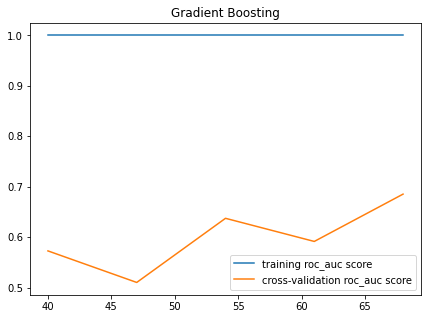

In [31]:
N, train_score_GB_und_final, val_score_GB_und_final = learning_curve(GB_und_final, X_train_rus, y_train_rus,  scoring='roc_auc',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

print(N)
plt.figure(figsize=(7, 5))
plt.plot(N, train_score_GB_und_final.mean(axis=1), label='training roc_auc score')
plt.plot(N, val_score_GB_und_final.mean(axis=1), label='cross-validation roc_auc score')
plt.xlabel('')
plt.title('Gradient Boosting')

plt.legend()
plt.show()

0.6607843137254902


Text(0.5, 0, 'Taux de faux positifs')

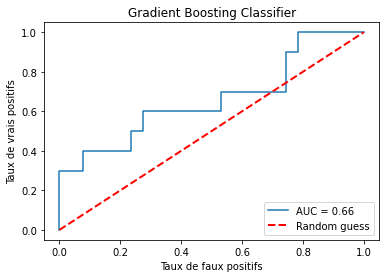

In [32]:
yPred = GB_und_final.predict_proba(X_test)
yPred = yPred[:, 1]

fpr, tpr, _ = roc_curve(y_test, yPred)
roc_auc = auc(fpr, tpr)
print(roc_auc_score(y_test, yPred))
plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.legend(loc='lower right')
plt.title('Gradient Boosting Classifier')
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')

## Regression Logistique

In [44]:
numerical_features = ['age',  'proteins', 'crp_pleu', 'ldh', 'glucose', 'IMC']
categorical_features = ['cancer']

# On doit encoder les variables qualitatives en numérique[oui/non en 1/0] et pour certains algorithmes il 
# est nécessaire de normaliser les données
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

# Construire les pipelines qui vont permettre de faire les transformations succèssives de chaque type de variables
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
logistic_model = LogisticRegression(random_state=0)

In [45]:
column_trans = make_column_transformer((OneHotEncoder(), categorical_features),
                                       remainder = RobustScaler())
column_trans

ColumnTransformer(remainder=RobustScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(), ['cancer'])])

In [46]:
X_train_trans = column_trans.fit_transform(X_train)
column_scale = make_column_transformer(('passthrough', categorical_features),(RobustScaler(),  numerical_features))
column_scale

ColumnTransformer(transformers=[('passthrough', 'passthrough', ['cancer']),
                                ('robustscaler', RobustScaler(),
                                 ['age', 'proteins', 'crp_pleu', 'ldh',
                                  'glucose', 'IMC'])])

In [47]:
X_train_scale =column_scale.fit_transform(X_train)

In [51]:
X_train_trans_rus = column_trans.fit_transform(X_train_rus)
X_train_scale_rus =column_scale.fit_transform(X_train_rus)

In [52]:
LR_und.fit(X_train_rus, y_train_rus)

LogisticRegression(random_state=1)

In [53]:
# Définir la plage des hyperparamètres
distributions = dict(penalty = ['l1', 'l2', 'elasticnet', None],
                     max_iter=np.arange(1000,10000),
                     solver= ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])

# Configurer la recherche aléatoire
Rand_CV = RandomizedSearchCV(LR_und, distributions, random_state=0, scoring = 'f1')
search =  Rand_CV.fit(X_train_trans_rus, y_train_rus)
 
search.best_params_ 

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 55, in _check_solver
    raise ValueError(
ValueError: Logist

{'solver': 'saga', 'penalty': 'l2', 'max_iter': 8373}

In [54]:
logistic_model_rus = LogisticRegression(random_state=0)
logistic_model_rus.fit(X_train_trans_rus, y_train_rus)

LogisticRegression(random_state=0)

In [55]:
logistic_model_rus_final =LogisticRegression(solver= 'liblinear', penalty= 'l2',max_iter= 2815, random_state=0)
logistic_model_rus_final.fit(X_train_trans_rus, y_train_rus)

LogisticRegression(max_iter=2815, random_state=0, solver='liblinear')

In [56]:
# Calcul du score obtenu durant la validation croisée pour le modèle de base sur le train set

cross_validation =10 
score_f1 = cross_val_score(logistic_model_rus_final, X_train_rus, y_train_rus, cv=cross_validation, scoring ="f1")
score_auc = cross_val_score(logistic_model_rus_final, X_train_rus, y_train_rus, cv=cross_validation, scoring ="roc_auc")
print('score folds F1')
print(score_f1)
print('Mean CV F1', '{:.3f}'.format(score_f1.mean()))
print('standard deviation CV F1', '{:.3f}'.format(np.std(score_f1)))
print('####################################################################')

print('score folds AUC')
print(score_auc)
print('Mean CV AUC:', '{:.3f}'.format(score_auc.mean()))
print('standard deviation CV AUC:', '{:.3f}'.format(np.std(score_auc)))

score folds F1
[0.5        0.75       0.75       0.         1.         0.75
 0.66666667 0.75       0.66666667 0.66666667]
Mean CV F1 0.650
standard deviation CV F1 0.247
####################################################################
score folds AUC
[0.625      0.75       0.75       0.4375     1.         0.6875
 1.         0.83333333 0.75       0.91666667]
Mean CV AUC: 0.775
standard deviation CV AUC: 0.165


In [57]:
X_train_trans_rus =column_trans.fit_transform(X_train_rus)
X_test_trans_rus = column_trans.transform(X_test)
print("Logistic Regression final")
evaluation(model = logistic_model_rus_final, X_test = X_test_trans_rus)

Logistic Regression final
CONFUSION MATRIX
[[37 14]
 [ 3  7]]
              precision    recall  f1-score   support

           0       0.93      0.73      0.81        51
           1       0.33      0.70      0.45        10

    accuracy                           0.72        61
   macro avg       0.63      0.71      0.63        61
weighted avg       0.83      0.72      0.75        61

SPECIFICITY
[0.7       0.7254902]
AUROC
0.8019607843137255


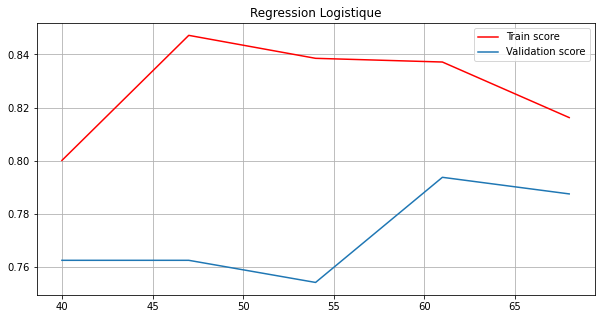

In [58]:
N, train_score_logistic_model_rus_final, val_score_logistic_model_rus_final = learning_curve(logistic_model_rus_final, X_train_trans_rus, y_train_rus,  scoring='roc_auc',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

figure, axis = plt.subplots(figsize=(10, 5))

axis.plot(N, train_score_logistic_model_rus_final.mean(axis=1), color = "red")    
axis.plot(N, val_score_logistic_model_rus_final.mean(axis=1))
axis.set_title("Regression Logistique")
axis.legend(['Train score', 'Validation score'])
axis.grid(visible = None)

[ 6 13 20 27 34 40 47 54 61 68]


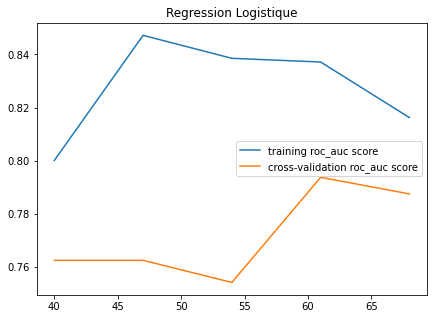

In [59]:
N, train_score_logistic_model_rus_final, val_score_logistic_model_rus_final = learning_curve(logistic_model_rus_final, X_train_trans_rus, y_train_rus,  scoring='roc_auc',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

print(N)
plt.figure(figsize=(7, 5))
plt.plot(N, train_score_logistic_model_rus_final.mean(axis=1), label='training roc_auc score')
plt.plot(N, val_score_logistic_model_rus_final.mean(axis=1), label='cross-validation roc_auc score')
plt.xlabel('')
plt.title('Regression Logistique')

plt.legend()
plt.show()

0.8019607843137255


Text(0.5, 0, 'Taux de faux positifs')

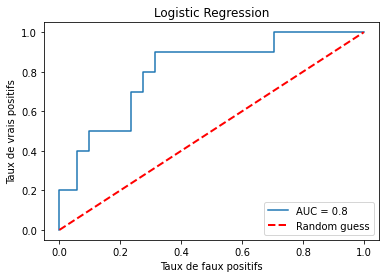

In [60]:
yPred = logistic_model_rus_final.predict_proba(X_test_trans_rus)
yPred = yPred[:, 1]

fpr, tpr, _ = roc_curve(y_test, yPred)
roc_auc = auc(fpr, tpr)
print(roc_auc_score(y_test, yPred))
plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.legend(loc='lower right')
plt.title('Logistic Regression')
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')

## Reseau de neurone

In [61]:
ANN_und.fit(X_train_trans_rus, y_train_rus)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=1)

In [62]:
# Définir la plage des hyperparamètres
distributions = dict(hidden_layer_sizes=np.arange(1,1000))

# Configurer la recherche aléatoire
Rand_CV = RandomizedSearchCV(ANN_und, distributions, random_state=0, scoring = 'roc_auc')
search =  Rand_CV.fit(X_train_trans_rus, y_train_rus)
 
search.best_params_

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

{'hidden_layer_sizes': 32}

In [63]:
ANN_rus_final= MLPClassifier(hidden_layer_sizes=723, random_state=0)
ANN_rus_final.fit(X_train_trans_rus, y_train_rus)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=723, random_state=0)

In [64]:
cross_validation =10 
score_f1 = cross_val_score(ANN_rus_final, X_train_trans_rus, y_train_rus, cv=cross_validation, scoring ="f1")
score_auc = cross_val_score(ANN_rus_final, X_train_trans_rus, y_train_rus, cv=cross_validation, scoring ="roc_auc")
print('score folds F1')
print(score_f1)
print('Mean CV F1', '{:.3f}'.format(score_f1.mean()))
print('standard deviation CV F1', '{:.3f}'.format(np.std(score_f1)))
print('####################################################################')

print('score folds AUC')
print(score_auc)
print('Mean CV AUC:', '{:.3f}'.format(score_auc.mean()))
print('standard deviation CV AUC:', '{:.3f}'.format(np.std(score_auc)))

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

score folds F1
[0.5        0.66666667 1.         0.33333333 0.88888889 0.33333333
 0.66666667 0.66666667 0.57142857 0.4       ]
Mean CV F1 0.603
standard deviation CV F1 0.212
####################################################################
score folds AUC
[0.625      0.8125     1.         0.6875     0.9375     0.4375
 0.66666667 0.83333333 0.58333333 0.91666667]
Mean CV AUC: 0.750
standard deviation CV AUC: 0.170


C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [65]:
print("Reseau de neuronefinal")
evaluation(model = ANN_rus_final, X_test = X_test_trans_rus)

Reseau de neuronefinal
CONFUSION MATRIX
[[34 17]
 [ 3  7]]
              precision    recall  f1-score   support

           0       0.92      0.67      0.77        51
           1       0.29      0.70      0.41        10

    accuracy                           0.67        61
   macro avg       0.61      0.68      0.59        61
weighted avg       0.82      0.67      0.71        61

SPECIFICITY
[0.7        0.66666667]
AUROC
0.792156862745098


C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

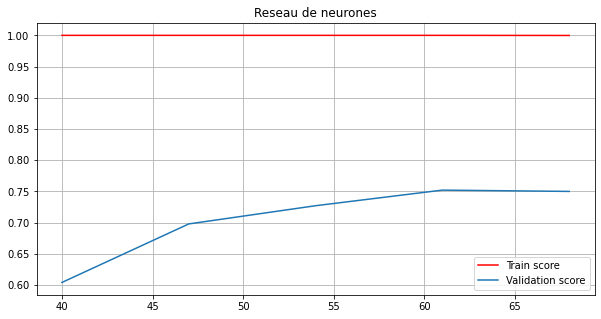

In [66]:
N, train_score_ANN_rus_final, val_score_ANN_rus_final = learning_curve(ANN_rus_final, X_train_trans_rus, y_train_rus,  scoring='roc_auc',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

figure, axis = plt.subplots(figsize=(10, 5))

axis.plot(N, train_score_ANN_rus_final.mean(axis=1), color = "red")    
axis.plot(N, val_score_ANN_rus_final.mean(axis=1))
axis.set_title("Reseau de neurones")
axis.legend(['Train score', 'Validation score'])
axis.grid(visible = None)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

[ 6 13 20 27 34 40 47 54 61 68]


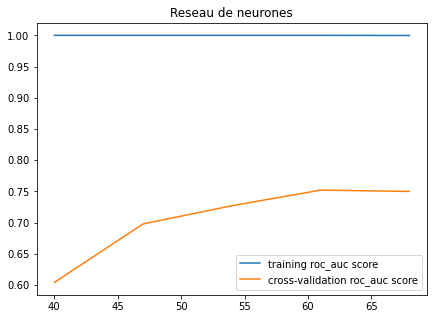

In [67]:
N, train_score_ANN_rus_final, val_score_ANN_rus_final = learning_curve(ANN_rus_final, X_train_trans_rus, y_train_rus,  scoring='roc_auc',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

print(N)
plt.figure(figsize=(7, 5))
plt.plot(N, train_score_ANN_rus_final.mean(axis=1), label='training roc_auc score')
plt.plot(N, val_score_ANN_rus_final.mean(axis=1), label='cross-validation roc_auc score')
plt.xlabel('')
plt.title('Reseau de neurones')

plt.legend()
plt.show()

0.792156862745098


Text(0.5, 0, 'Taux de faux positifs')

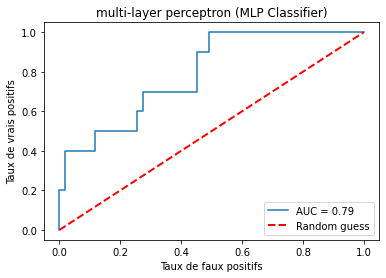

In [68]:
yPred = ANN_rus_final.predict_proba(X_test_trans_rus)
yPred = yPred[:, 1]

fpr, tpr, _ = roc_curve(y_test, yPred)
roc_auc = auc(fpr, tpr)
print(roc_auc_score(y_test, yPred))
plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.legend(loc='lower right')
plt.title('multi-layer perceptron (MLP Classifier)')
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    ret

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self.

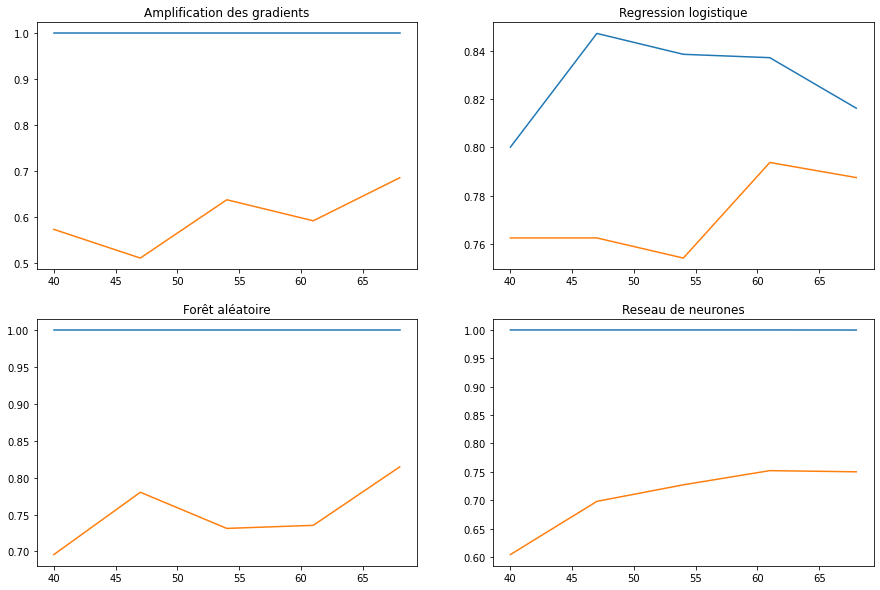

In [93]:

plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
# Learning curve of Gradient Boosting

N, train_score_GB_und_final, val_score_GB_und_final = learning_curve(GB_und_final, X_train_rus, y_train_rus,  scoring='roc_auc',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

plt.plot(N, train_score_GB_und_final.mean(axis=1), label='training roc_auc score')
plt.plot(N, val_score_GB_und_final.mean(axis=1), label='cross-validation roc_auc score')
plt.xlabel('')
plt.title('Amplification des gradients')


plt.subplot(2,2,2)
# Learning curve of Logistic regression
N, train_score_logistic_model_rus_final, val_score_logistic_model_rus_final = learning_curve(logistic_model_rus_final, X_train_trans_rus, y_train_rus,  scoring='roc_auc',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

plt.plot(N, train_score_logistic_model_rus_final.mean(axis=1), label='training roc_auc score')
plt.plot(N, val_score_logistic_model_rus_final.mean(axis=1), label='cross-validation roc_auc score')
plt.xlabel('')
plt.title('Regression logistique')


plt.subplot(2,2,3)
# Learning curve for Random Forest

N, train_score_RF_und, val_score_RF_und = learning_curve(RF_und_final, X_train_rus, y_train_rus,  scoring='roc_auc',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

plt.plot(N, train_score_RF_und.mean(axis=1), label='training roc_auc score')
plt.plot(N, val_score_RF_und.mean(axis=1), label='cross-validation roc_auc score')
plt.xlabel('')
plt.title('Forêt aléatoire')


plt.subplot(2,2,4)

# Learning curve for reseau de neuronne
N, train_score_ANN_rus_final, val_score_ANN_rus_final = learning_curve(ANN_rus_final, X_train_trans_rus, y_train_rus,  scoring='roc_auc',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

plt.plot(N, train_score_ANN_rus_final.mean(axis=1), label='training roc_auc score')
plt.plot(N, val_score_ANN_rus_final.mean(axis=1), label='cross-validation roc_auc score')
plt.xlabel('')
plt.title('Reseau de neurones')

plt.savefig("learning curve block 1.png")

plt.show()

0.7843137254901961
0.6607843137254902
0.8019607843137255
0.792156862745098


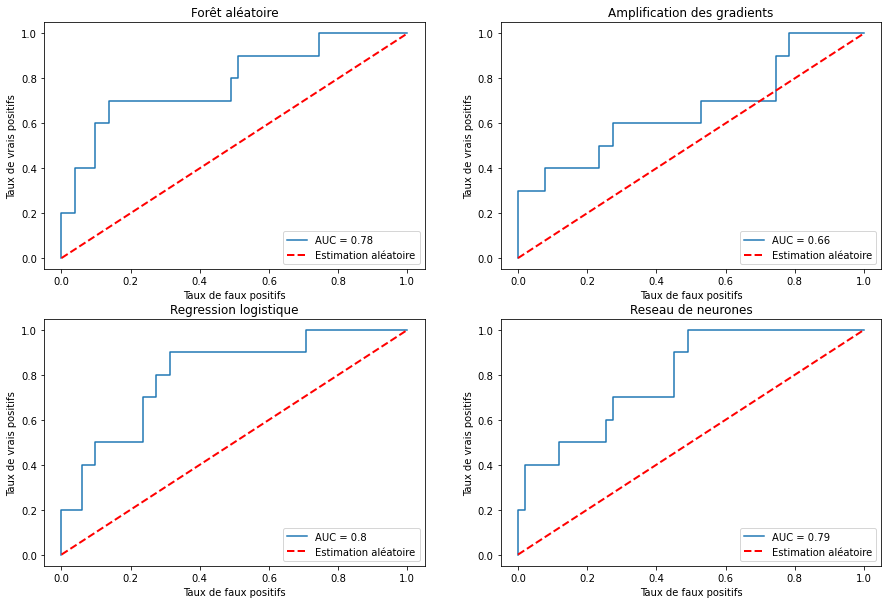

In [94]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
# Learning curve of Gradient Boosting

yPred = RF_und_final.predict_proba(X_test)
yPred = yPred[:, 1]

fpr, tpr, _ = roc_curve(y_test, yPred)
roc_auc = auc(fpr, tpr)
print(roc_auc_score(y_test, yPred))
plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Estimation aléatoire')
plt.legend(loc='lower right')
plt.title('Forêt aléatoire')
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')


plt.subplot(2,2,2)
# Learning curve of Logistic regression
yPred = GB_und_final.predict_proba(X_test)
yPred = yPred[:, 1]

fpr, tpr, _ = roc_curve(y_test, yPred)
roc_auc = auc(fpr, tpr)
print(roc_auc_score(y_test, yPred))
plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Estimation aléatoire')
plt.legend(loc='lower right')
plt.title('Amplification des gradients')
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')


plt.subplot(2,2,3)
# Learning curve for Random Forest

yPred = logistic_model_rus_final.predict_proba(X_test_trans_rus)
yPred = yPred[:, 1]

fpr, tpr, _ = roc_curve(y_test, yPred)
roc_auc = auc(fpr, tpr)
print(roc_auc_score(y_test, yPred))
plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Estimation aléatoire')
plt.legend(loc='lower right')
plt.title('Regression logistique')
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')


plt.subplot(2,2,4)

# Learning curve for reseau de neuronne
yPred = ANN_rus_final.predict_proba(X_test_trans_rus)
yPred = yPred[:, 1]

fpr, tpr, _ = roc_curve(y_test, yPred)
roc_auc = auc(fpr, tpr)
print(roc_auc_score(y_test, yPred))
plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Estimation aléatoire')
plt.legend(loc='lower right')
plt.title('Reseau de neurones')
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')

plt.savefig("learning curve block 1.png")

plt.show()